In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set(style="darkgrid")

Loads

First try `entsoe-py` - you need to request an API

In [56]:
# !pip install entsoe-py

In [ ]:
# from entsoe import EntsoeRawClient
# import pandas as pd

# client = EntsoeRawClient(api_key=<YOUR API KEY>)

# start = pd.Timestamp('20171201', tz='Europe/Brussels')
# end = pd.Timestamp('20180101', tz='Europe/Brussels')
# country_code = 'BE'  # Belgium

# # methods that return XML
# client.query_load(country_code, start, end)

In [55]:
# from entsoe import EntsoePandasClient
# import pandas as pd

# client = EntsoePandasClient(api_key=<YOUR API KEY>)

# start = pd.Timestamp('20171201', tz='Europe/Brussels')
# end = pd.Timestamp('20180101', tz='Europe/Brussels')
# country_code = 'BE'  # Belgium

# # methods that return Pandas Series
# client.query_load(country_code, start=start,end=end)

Create ID, login

https://transparency.entsoe.eu/ Load -> Total Load Day-ahead/Actual -> Country -> UK -> Export Data -> Year, CSV

Export last 5 years

In [6]:
dfs=[]
for i in range(2015,2020):
    dfs.append(pd.read_csv('Total Load - Day Ahead _ Actual_'+str(i)+'01010000-'+str(i+1)+'01010000.csv'))
df=pd.concat(dfs)

In [7]:
df['ts']=pd.to_datetime([i[0] for i in df['Time (CET)'].str.split('-')],dayfirst=True)
df=df.set_index('ts',drop=False).sort_index()
load='Average UK Load in GW\n 01-01-2015 to 31-12-2019'
df[load]=df['Actual Total Load [MW] - United Kingdom (UK)'].replace('-',np.nan).astype(float)/1000
df[load]=df[load].rolling(3).mean()
df['day']=df['ts'].dt.weekday_name
time='Time of day'
df[time]=df['ts'].dt.time
df['Month']=df['ts'].dt.month
df['date']=df['ts'].dt.date.astype(str)

In [8]:
!pip install govuk-bank-holidays

In [9]:
from govuk_bank_holidays.bank_holidays import BankHolidays

bhs={}
bank_holidays = BankHolidays()
for bank_holiday in bank_holidays.get_holidays():
    print(bank_holiday['title'], '>', bank_holiday['date'])
    bhs[str(bank_holiday['date'])]=bank_holiday['title']

New Year’s Day > 2015-01-01
Good Friday > 2015-04-03
Early May bank holiday > 2015-05-04
Spring bank holiday > 2015-05-25
Christmas Day > 2015-12-25
Boxing Day > 2015-12-28
New Year’s Day > 2016-01-01
Good Friday > 2016-03-25
Early May bank holiday > 2016-05-02
Spring bank holiday > 2016-05-30
Boxing Day > 2016-12-26
Christmas Day > 2016-12-27
New Year’s Day > 2017-01-02
Good Friday > 2017-04-14
Early May bank holiday > 2017-05-01
Spring bank holiday > 2017-05-29
Christmas Day > 2017-12-25
Boxing Day > 2017-12-26
New Year’s Day > 2018-01-01
Good Friday > 2018-03-30
Early May bank holiday > 2018-05-07
Spring bank holiday > 2018-05-28
Christmas Day > 2018-12-25
Boxing Day > 2018-12-26
New Year’s Day > 2019-01-01
Good Friday > 2019-04-19
Early May bank holiday > 2019-05-06
Spring bank holiday > 2019-05-27
Christmas Day > 2019-12-25
Boxing Day > 2019-12-26
New Year’s Day > 2020-01-01
Good Friday > 2020-04-10
Early May bank holiday (VE day) > 2020-05-08
Spring bank holiday > 2020-05-25
Chri

In [10]:
len([i for i in bhs if i<'2020-01-01'])

30

In [11]:
label='Day type'
labels=[]
for i in df[['date','day']].values:
    if i[1] in ['Saturday','Sunday']:
        d='Weekend'
    else:
        d='Weekday'
    if i[0] in bhs:
        d='Bank Holiday'
    labels.append(d)
df[label]=labels

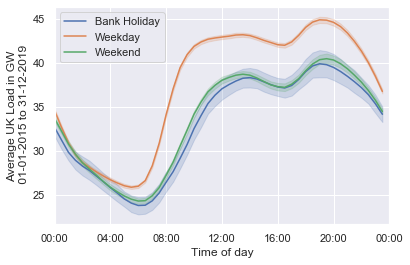

In [12]:
# Plot the responses for different events and regions
sns.lineplot(x=time, y=load,
             hue=label, 
             #style="day",
             data=df)
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.xlim(0,24*60*60)
plt.xticks(range(0,24*60*60+1,4*60*60))
plt.savefig('1.png',bbox_inches='tight',dpi=300)

In [13]:
1-df.groupby('Day type').mean()[[load]].loc['Weekend']/df.groupby('Day type').mean()[[load]].loc['Weekday']

Average UK Load in GW\n 01-01-2015 to 31-12-2019    0.099754
dtype: float64

In [14]:
1-df.groupby('Day type').mean()[[load]].loc['Bank Holiday']/df.groupby('Day type').mean()[[load]].loc['Weekday']

Average UK Load in GW\n 01-01-2015 to 31-12-2019    0.115625
dtype: float64

In [15]:
label='Day type'
labels=[]
pretty={'1e':'January Weekday','5e':'May Weekday','7e':'July Weekday',
        '1k':'January Weekend','5k':'May Weekend','7k':'July Weekend'}
for i in df[['date','day','Month']].values:
    d='Other'
    if i[0] in bhs:
        if bhs[i[0]] in ['Early May bank holiday','Spring bank holiday']:
            d=bhs[i[0]].replace('bank holiday','BH')
    elif i[1] in ['Saturday','Sunday']:
        if i[2] in [1,5,7]:
            d=pretty[str(i[2])+'k']
    labels.append(d)
df[label]=labels

In [16]:
[j for j in [i for i in bhs if bhs[i] in ['Early May bank holiday','Spring bank holiday']] if j<'2020-01-01']

['2015-05-04',
 '2015-05-25',
 '2016-05-02',
 '2016-05-30',
 '2017-05-01',
 '2017-05-29',
 '2018-05-07',
 '2018-05-28',
 '2019-05-06',
 '2019-05-27']

In [17]:
data=df[df[label]!='Other']

In [18]:
1-data.groupby('Day type').mean()[[load]].loc['Early May BH']/data.groupby('Day type').mean()[[load]].loc['May Weekend']

Average UK Load in GW\n 01-01-2015 to 31-12-2019   -0.055509
dtype: float64

In [19]:
1-data.groupby('Day type').mean()[[load]].loc['Spring BH']/data.groupby('Day type').mean()[[load]].loc['May Weekend']

Average UK Load in GW\n 01-01-2015 to 31-12-2019    0.038206
dtype: float64

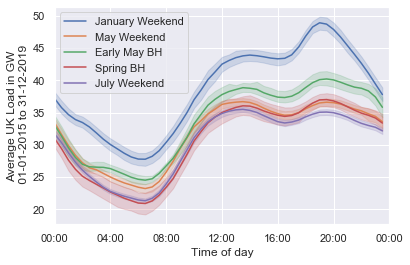

In [20]:
# Plot the responses for different events and regions
sns.lineplot(x=time, y=load,
             hue=label, 
             #style="day",
             data=df[df[label]!='Other'])
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.xlim(0,24*60*60)
plt.xticks(range(0,24*60*60+1,4*60*60))
plt.savefig('2.png',bbox_inches='tight',dpi=300)

In [21]:
label='Day type'
style=' '
labels=[]
styles=[]
pretty={1:'January',7:'July'}
for i in df[['date','day','Month']].values:
    if i[1] in ['Saturday','Sunday']:
        d='Weekend'
    else:
        d='Weekday'
    if i[2] in [1,7]:
        s=pretty[i[2]]
    else:
        s='Other'
    labels.append(d)
    styles.append(s)
df[label]=labels
df[style]=styles

In [22]:
dz=df[df['Month']==7].groupby('Day type').mean()[[load]]

Prices

Export last 5 years

https://transparency.entsoe.eu/ Transmission -> Day-ahead Prices -> Bidding Zone -> UK (BZN|GB) -> UTC -> Export Data -> Year, CSV

In [23]:
rfs=[]
for i in range(2015,2020):
    rfs.append(pd.read_csv('Day-ahead Prices_'+str(i)+'01010000-'+str(i+1)+'01010000.csv'))
rf=pd.concat(rfs)

In [24]:
rf['ts']=pd.to_datetime([i[0] for i in rf['MTU (UTC)'].str.split('-')],dayfirst=True)
rf=rf.set_index('ts',drop=False).sort_index()
price='Average UK Day-ahead Price in £/MWh\n 01-01-2015 to 31-12-2019'
rf[price]=rf['Day-ahead Price [GBP/MWh]'].replace('-',np.nan).astype(float)
rf[price]=rf[price].rolling(3).mean()
rf['day']=rf['ts'].dt.weekday_name
rf[time]=rf['ts'].dt.time
rf['Month']=rf['ts'].dt.month
rf['date']=rf['ts'].dt.date.astype(str)

In [25]:
label='Day type'
style=' '
labels=[]
styles=[]
pretty={1:'January',7:'July'}
for i in rf[['date','day','Month']].values:
    if i[1] in ['Saturday','Sunday']:
        d='Weekend'
    else:
        d='Weekday'
    if i[2] in [1,7]:
        s=pretty[i[2]]
    else:
        s='Other'
    labels.append(d)
    styles.append(s)
rf[label]=labels
rf[style]=styles

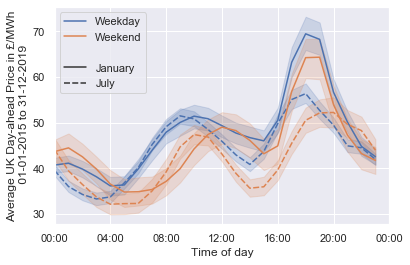

In [26]:
# Plot the responses for different events and regions
sns.lineplot(x=time, y=price,
             hue=label, 
             style=style,
             data=rf[rf[style]!='Other'])
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.xlim(0,24*60*60)
plt.xticks(range(0,24*60*60+1,4*60*60))
plt.savefig('3.png',bbox_inches='tight',dpi=300)

In [27]:
rz=rf[rf['Month']==1].groupby('Day type').mean()[[price]]
1-rz.loc['Weekend']/rz.loc['Weekday']

Average UK Day-ahead Price in £/MWh\n 01-01-2015 to 31-12-2019    0.059045
dtype: float64

In [28]:
rz=rf[rf['Month']==7].groupby('Day type').mean()[[price]]
1-rz.loc['Weekend']/rz.loc['Weekday']

Average UK Day-ahead Price in £/MWh\n 01-01-2015 to 31-12-2019    0.063648
dtype: float64

Carbon

https://carbonintensity.org.uk/ - Download the Data

In [29]:
fs=[str(i)+str(j+1) if j>8 else str(i)+'0'+str(j+1) for i in range(2017,2020) for j in range(12)][8:]
wfs=[]
for f in fs:
    wfs.append(pd.read_csv('Carbon_Intensity_Data'+f+'.csv'))
wf=pd.concat(wfs)

In [30]:
wf['ts']=pd.to_datetime(wf['Datetime (UTC)'])
wf=wf.set_index('ts',drop=False).sort_index()
carbon='UK Electricity Carbon Intensity in gCO2/kWh\n 26-07-2017 to 31-12-2019'
wf[carbon]=wf['Actual Carbon Intensity (gCO2/kWh)'].astype(float)
wf[price]=wf[carbon].rolling(3).mean()
wf['day']=wf['ts'].dt.weekday_name
wf[time]=wf['ts'].dt.time
wf['Month']=wf['ts'].dt.month
wf['date']=wf['ts'].dt.date.astype(str)

In [31]:
label='Day type'
style=' '
labels=[]
styles=[]
pretty={1:'January',7:'July'}
for i in wf[['date','day','Month']].values:
    if i[1] in ['Saturday','Sunday']:
        d='Weekend'
    else:
        d='Weekday'
    if i[2] in [1,7]:
        s=pretty[i[2]]
    else:
        s='Other'
    labels.append(d)
    styles.append(s)
wf[label]=labels
wf[style]=styles

In [32]:
wz=wf.groupby('Day type').mean()[[carbon]]

In [33]:
1-wz.loc['Weekend']/wz.loc['Weekday']

UK Electricity Carbon Intensity in gCO2/kWh\n 26-07-2017 to 31-12-2019    0.133054
dtype: float64

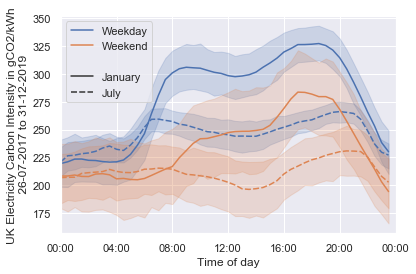

In [34]:
# Plot the responses for different events and regions
sns.lineplot(x=time, y=carbon,
             hue=label, 
             style=style,
             data=wf[wf[style]!='Other'])
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.xlim(0,24*60*60)
plt.xticks(range(0,24*60*60+1,4*60*60))
plt.savefig('4.png',bbox_inches='tight',dpi=300)

In [35]:
wz=wf[wf['Month']==1].groupby('Day type').mean()[[carbon]]
1-wz.loc['Weekend']/wz.loc['Weekday']

UK Electricity Carbon Intensity in gCO2/kWh\n 26-07-2017 to 31-12-2019    0.15649
dtype: float64

In [36]:
wz=wf[wf['Month']==7].groupby('Day type').mean()[[carbon]]
1-wz.loc['Weekend']/wz.loc['Weekday']

UK Electricity Carbon Intensity in gCO2/kWh\n 26-07-2017 to 31-12-2019    0.139545
dtype: float64

Emissions

In [37]:
emi='Carbon Emissions Rate of\nUK Electricity in ktCO2/h\n26-07-2017 to 31-12-2019'
df[emi]=df[load]
l=df[[time,emi,'Day type','Month']]
wf[emi]=wf[carbon]
w=wf[[time,emi,'Day type','Month']]
w.index=w.index.tz_convert("UTC")
l.index=l.index.tz_localize('UTC')
w=w.set_index([time,'Day type','Month'])
l=l.set_index([time,'Day type','Month'])
q=(w*l*2/1000).reset_index() #/2 for half-hours /1000 for units
q=q[((q['Month']==1)|(q['Month']==7))]
q[style]=q['Month'].replace(1,'January').replace(7,'July')

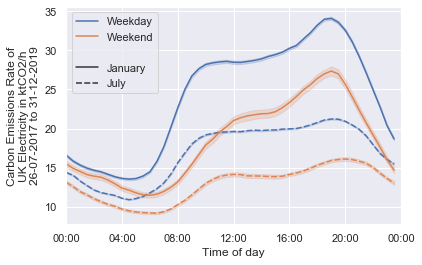

In [38]:
# Plot the responses for different events and regions
sns.lineplot(x=time, y=emi,
             hue=label, 
             style=style,
             data=q.dropna())
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.xlim(0,24*60*60)
plt.xticks(range(0,24*60*60+1,4*60*60))
plt.savefig('5.png',bbox_inches='tight',dpi=300)

In [39]:
qz=q.groupby(['Day type']).mean()[[emi]]

In [40]:
1-qz.loc['Weekend']/qz.loc['Weekday']

Carbon Emissions Rate of\nUK Electricity in ktCO2/h\n26-07-2017 to 31-12-2019    0.241362
dtype: float64

https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/789811/Final_greenhouse_gas_emissions_tables_2017.xlsx

UK energy supply emissions:
- 2017: 112.6 MtCO2e
- 2016: 121.8
- 2015: 145.3
- 2014: 165.2

In [70]:
#daily
print(112.6/365*1000) #kt 2017
print(145.3/365*1000) #kt 2015

308.4931506849315
398.0821917808219


In [71]:
#week
print(112.6/365*1000*7) #kt 2017
print(145.3/365*1000*7) #kt 2015

2159.4520547945203
2786.5753424657532


In [78]:
#savings per week
print(117/(112.6/365*1000*7)) #kt 2017
print(117/2159)
print(117/(145.3/365*1000*7)) #kt 2015

0.05418041106318194
0.05419175544233441
0.041987021925081115


In [76]:
qz=(q.groupby([style,label,time]).mean()[[emi]]/2).reset_index().groupby([label,style]).sum()

In [77]:
1-qz.loc['Weekend']/qz.loc['Weekday']

,Carbon Emissions Rate of\nUK Electricity in ktCO2/h\n26-07-2017 to 31-12-2019
,
January,0.235099
July,0.241450


In [64]:
(1-qz.loc['Weekend']/qz.loc['Weekday']).mean().values[0]/7

0.03403916470861281

In [68]:
1-(6+(qz.loc['Weekend']/qz.loc['Weekday']).mean().values[0])/7

0.03403916470861279

In [45]:
qz.loc['Weekend']-qz.loc['Weekday']

,Carbon Emissions Rate of\nUK Electricity in ktCO2/h\n26-07-2017 to 31-12-2019
,
January,-135.896292
July,-98.153793


In [46]:
(qz.loc['Weekend']-qz.loc['Weekday']).mean().values[0]

-117.0250426510764

https://www.epa.gov/greenvehicles/greenhouse-gas-emissions-typical-passenger-vehicle

In [47]:
(qz.loc['Weekend']-qz.loc['Weekday']).mean().values[0]*52*1000/4.6 #cars removed

-1322891.786490429

In [80]:
117*52*1000

6084000

In [81]:
117*52*1000/4.6

1322608.695652174

Stacked

Download past 5 years

https://transparency.entsoe.eu/ Generation -> Actual Generation per Production Type -> Country -> UK -> Export Data -> Year, CSV

In [48]:
sources={'Biomass  - Actual Aggregated [MW]':'Other',
       'Fossil Brown coal/Lignite  - Actual Aggregated [MW]':'Coal',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]':'Coal',
       'Fossil Gas  - Actual Aggregated [MW]':'Natural Gas',
       'Fossil Hard coal  - Actual Aggregated [MW]':'Coal',
       'Fossil Oil  - Actual Aggregated [MW]':'Other',
       'Fossil Oil shale  - Actual Aggregated [MW]':'Other',
       'Fossil Peat  - Actual Aggregated [MW]':'Coal',
       'Geothermal  - Actual Aggregated [MW]':'Other',
       'Hydro Pumped Storage  - Actual Aggregated [MW]':'Other',
       'Hydro Pumped Storage  - Actual Consumption [MW]':'Other',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]':'Other',
       'Hydro Water Reservoir  - Actual Aggregated [MW]':'Other',
       'Marine  - Actual Aggregated [MW]':'Other', 
       'Nuclear  - Actual Aggregated [MW]':'Nuclear',
       'Other  - Actual Aggregated [MW]':'Other',
       'Other renewable  - Actual Aggregated [MW]':'Other',
       'Solar  - Actual Aggregated [MW]':'Solar', 
       'Waste  - Actual Aggregated [MW]':'Other',
       'Wind Offshore  - Actual Aggregated [MW]':'Wind',
       'Wind Onshore  - Actual Aggregated [MW]':'Wind'}
src=list(set(sources.values()))

In [49]:
pfs=[]
for i in range(2015,2020):
    pfs.append(pd.read_csv('Actual Generation per Production Type_'+str(i)+'01010000-'+str(i+1)+'01010000.csv'))
pf=pd.concat(pfs)

In [50]:
pf['ts']=pd.to_datetime([i[0] for i in pf['MTU'].str.split('-')],dayfirst=True)
pf=pf.set_index('ts').sort_index()
pf=pf[sources.keys()].fillna(0)
for p in src:
    pf[p]=0
for p in set(sources.keys()):
    pf[sources[p]]=pf[sources[p]]+pf[p].replace('n/e',0).replace('-',0).astype(float)
pf=pf[src]
pf=pf.rolling(3).mean()
pf['ts']=pf.index
pf['day']=pf['ts'].dt.weekday_name
pf[time]=pf['ts'].dt.time
pf['Month']=pf['ts'].dt.month
pf['Year']=pf['ts'].dt.year
pf['date']=pf['ts'].dt.date.astype(str)

In [51]:
label='Day type'
style=' '
labels=[]
styles=[]
pretty={1:'January',7:'July'}
for i in pf[['date','day','Month']].values:
    if i[1] in ['Saturday','Sunday']:
        d='Weekend'
    else:
        d='Weekday'
    if i[2] in [1,7]:
        s=pretty[i[2]]
    else:
        s='Other'
    labels.append(d)
    styles.append(s)
pf[label]=labels
pf[style]=styles

In [52]:
src2=['Nuclear','Wind','Solar','Natural Gas','Coal','Other']
clr2=['#1d91c0','#a6d96a','#fdae61','#dd3497','#ae017e','#5e4fa2']
fuels=[u'hydro',u'nuclear',u'biofuels',u'other',u'biomass',u'coal',u'oil',u'gas',u'geoth.',u'wind',u'PV',u'CSP']
fuelcolors=['#41b6c4','#1d91c0','#225ea8','#253494','#5e4fa2','#7a0177','#ae017e','#dd3497','#a6d96a','#d9ef8b','#fee08b','#fdae61']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


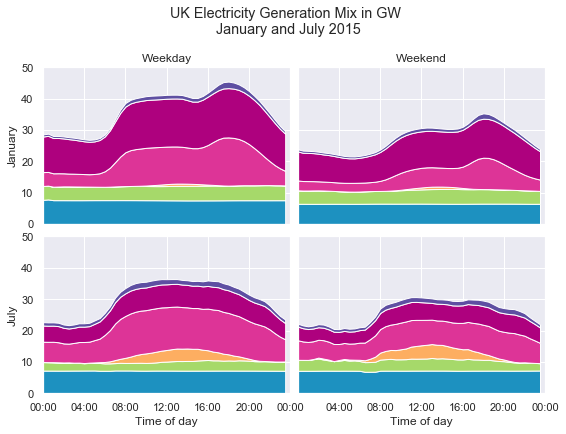

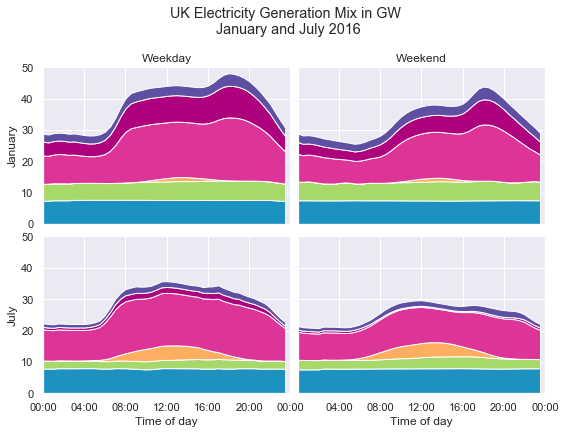

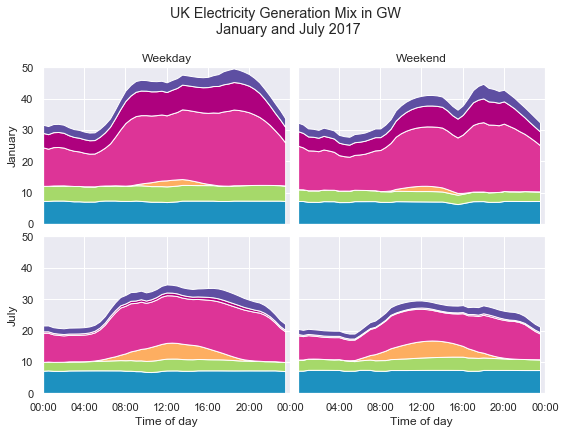

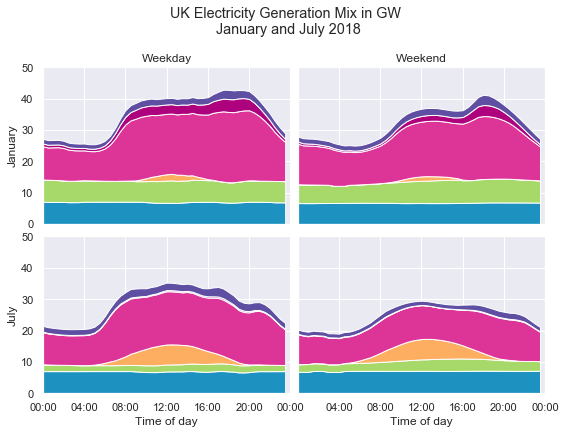

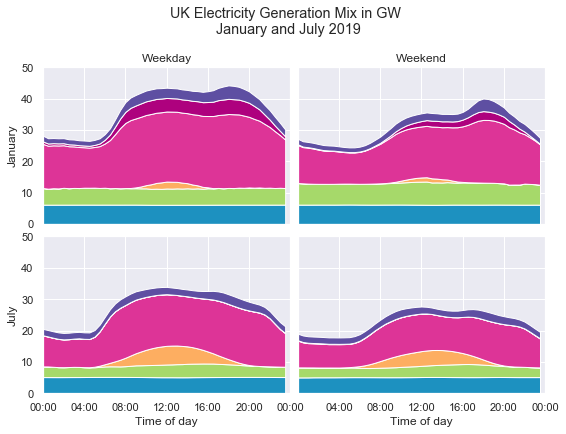

In [54]:
for year in range(2015,2020):
    ppf=pf[pf['Year']==year]
    stack='UK Electricity Generation Mix in GW\n January and July '+str(year)
    fig,axes=plt.subplots(2,2,figsize=(9,6))
    plt.subplots_adjust(wspace=0.03,hspace=0.08)
    m=['January','July']
    w=['Weekday','Weekend']
    for i in range(len(m)):
        for j in range(len(w)):
            pz=(ppf[((ppf[style]==m[i])&(pf[label]==w[j]))].groupby(time).mean()[src2]/1000).astype(float).dropna(how='all',axis=1)
            ax=axes[i][j]
            ax.stackplot(pz.index,pz.T.values, labels=pz.columns,colors=clr2)
            if j==0:
                ax.set_ylabel(m[i])
                ax.set_xticks([i for i in range(0,24*60*60+1,4*60*60)][:])
            else:
                ax.set_yticklabels([])
                ax.set_xticks([i for i in range(0,24*60*60+1,4*60*60)][1:])
            #if i==0 and j==0:
            #    handles, labels = ax.get_legend_handles_labels()
            #    ax.legend(handles=handles[::-1], labels=labels[::-1],loc='upper left')     
            ax.set_xlim(0,24*60*60)
            ax.set_ylim(0,50)
            if i==1:
                ax.set_xlabel(time)
            else:
                ax.set_xlabel('')
                ax.set_xticklabels([])
                ax.set_title(w[j])
    fig.suptitle(stack,y=1.02)              
    fig.savefig('c'+str(year)+'.png',bbox_inches='tight',dpi=300)